In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from keras.models import Model
from keras.layers import GRU, concatenate, Input, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

modelList = []
history = []
xaxis = []  
refit_history = []
refit_xaxis = []
    
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.start = time.time()
    #def on_epoch_begin(self, batch, logs={}):
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.start)
        
from keras.callbacks import Callback
class TimedStopping(Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, verbose=0):
        super(Callback, self).__init__()

        self.start_time = 0
        self.seconds = seconds
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs={}):
        if time.time() - self.start_time > self.seconds:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)
                
def Plot(i, text = 'acc', label = ''):
    plt.plot(xaxis[i], history[i].history['val_'+text], label = label)
def Plot2(i, j, text = 'acc', label = ''):
    plt.plot(xaxis[i]+[t+xaxis[i][-1] for t in refit_xaxis[j]]
             , history[i].history['val_'+text]+refit_history[j].history['val_'+text], label = label)

Using TensorFlow backend.


# Already done, do not do again

In [2]:
weatherData = np.concatenate((np.load('weatherData1991.npy'),np.load('FullweatherData.npy'),np.load('weatherData2000_04.npy'),
                             np.load('weatherData2005_09.npy'),np.load('weatherData2010_15.npy')))
df = (pd.DataFrame(np.load('NewFireData.npy'), columns=['day', 'lat', 'lon', 'num_cause', 'tarray', 'xybinarray', 'fire'])
      .drop('num_cause',axis=1).astype(int, copy=False))

def moddf(df):
    df0 = df.drop(['tarray', 'xybinarray'],axis=1).values
    df0 = (df0-df0.mean())/ df0.std()
    
    tarray = df['tarray'].values
    xybinarray = df['xybinarray'].values
    df1 = np.empty((len(df),31,4))
    for i in range(0,31):
        for j in range(0,4):
            df1[:,i,j] = weatherData[tarray-i, xybinarray,j]
    # Normalize features
    df1 = (df1-df1.mean())/ df1.std()
    
    return df0, df1

xdf = df.drop('fire',axis=1)
y = df['fire'].values
x0, x1 = moddf(xdf)
X0, X0_test, X1, X1_test, y, y_test = train_test_split(
    x0, x1, y, test_size=0.1, shuffle=True)
X0_train, X0_val, X1_train, X1_val, y_train, y_val = train_test_split(
    X0, X1, y, test_size=0.1, shuffle=True)

np.save('X0_train', X0_train, allow_pickle=True, fix_imports=False)
np.save('X1_train', X1_train, allow_pickle=True, fix_imports=False)
np.save('y_train', y_train, allow_pickle=True, fix_imports=False)
np.save('X0_val', X0_val, allow_pickle=True, fix_imports=False)
np.save('X1_val', X1_val, allow_pickle=True, fix_imports=False)
np.save('y_val', y_val, allow_pickle=True, fix_imports=False)
np.save('X0_test', X0_test, allow_pickle=True, fix_imports=False)
np.save('X1_test', X1_test, allow_pickle=True, fix_imports=False)
np.save('y_test', y_test, allow_pickle=True, fix_imports=False)

# Train neuronet

In [2]:
X0_train = np.load('X0_train.npy', mmap_mode='r')
X1_train = np.load('X1_train.npy', mmap_mode='r')
y_train = np.load('y_train.npy', mmap_mode='r')
X0_val = np.load('X0_val.npy')
X1_val = np.load('X1_val.npy')
y_val = np.load('y_val.npy')
X0_test = np.load('X0_test.npy')
X1_test = np.load('X1_test.npy')
y_test = np.load('y_test.npy')

In [3]:
length_train = 2973745
indices = np.arange(length_train, dtype=int)

def generator(batchSize=512):
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(indices), batchSize):
            batch_indices = indices[i:i+batchSize]
            batch_indices.sort()

            bx0 = X0_train[batch_indices,...]
            bx1 = X1_train[batch_indices,...]
            by = y_train[batch_indices,...]

            yield ([bx0,bx1], by)

In [4]:
def fit(nUnits, batchSize, timelimit, nlayer):
    x0 = Input(shape=(3,)) # location
    x1 = Input(shape=(31,4)) # weather
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchSize),steps_per_epoch = 2973745//batchSize
                                        ,epochs=100, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model) 
    
def refit(batchsize, timelimit, model):
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    refit_history.append(model.fit_generator(generator(batchSize),steps_per_epoch = 2973745//batchSize
                                        ,epochs=200, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping, es]))
    refit_xaxis.append(time_callback.times)

In [16]:
fit(nUnits = 80, batchSize = 1024, timelimit = 300, nlayer = 1)

Epoch 1/100
5045s - loss: 0.6269 - acc: 0.6348 - val_loss: 0.6086 - val_acc: 0.6635


So the accuracy is very low after 5045 s (1.4 hours).

With less fires, I had an accuracy of 71% after 4000 s. Correlation in time might be useful and now it's harder to learn them because it's on more years.

Hopefully, it'll get better with more epochs.

Python is using 2.6 GB right now even with the generator. I should look what makes the memory usage.

In [22]:
# !!! Already done

modelList[0].save('my_model5045.h5')
# try save weight in case saving model doesn't work
modelList[0].save_weights('my_model_weights5045.h5')

In [5]:
from keras.models import load_model
model = load_model('my_model5045.h5')

ValueError: Layer gru_13 expects 1 inputs, but it received 2 input tensors. Input received: [<tf.Tensor 'input_10:0' shape=(?, 31, 4) dtype=float32>, <tf.Tensor 'dense_17/Relu:0' shape=(?, 80) dtype=float32>]

In [7]:
# In case it doesn't work
def fit_loadweight(nUnits, batchSize, timelimit, nlayer):
    x0 = Input(shape=(3,)) # location
    x1 = Input(shape=(31,4)) # weather
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    model.load_weights('my_model_weights5045.h5')
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchSize),steps_per_epoch = 2973745//batchSize
                                        ,epochs=100, verbose=2, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model)
    
fit_loadweight(nUnits = 80, batchSize = 1024, timelimit = 4*3600, nlayer = 1)

Epoch 1/100
1328s - loss: 0.6020 - acc: 0.6695 - val_loss: 0.5962 - val_acc: 0.6770
Epoch 2/100
582s - loss: 0.5928 - acc: 0.6782 - val_loss: 0.5904 - val_acc: 0.6811
Epoch 3/100
583s - loss: 0.5891 - acc: 0.6809 - val_loss: 0.5891 - val_acc: 0.6817
Epoch 4/100
582s - loss: 0.5866 - acc: 0.6830 - val_loss: 0.5867 - val_acc: 0.6826
Epoch 5/100
581s - loss: 0.5846 - acc: 0.6844 - val_loss: 0.5878 - val_acc: 0.6816
Epoch 6/100
581s - loss: 0.5830 - acc: 0.6855 - val_loss: 0.5834 - val_acc: 0.6855
Epoch 7/100
584s - loss: 0.5814 - acc: 0.6869 - val_loss: 0.5821 - val_acc: 0.6861
Epoch 8/100
582s - loss: 0.5798 - acc: 0.6879 - val_loss: 0.5832 - val_acc: 0.6860
Epoch 9/100
581s - loss: 0.5786 - acc: 0.6887 - val_loss: 0.5837 - val_acc: 0.6845
Epoch 10/100
583s - loss: 0.5773 - acc: 0.6898 - val_loss: 0.5801 - val_acc: 0.6871
Epoch 11/100
583s - loss: 0.5762 - acc: 0.6905 - val_loss: 0.5795 - val_acc: 0.6886
Epoch 12/100
585s - loss: 0.5749 - acc: 0.6916 - val_loss: 0.5782 - val_acc: 0.6892


The 5045s for the 1st epoch was probably inacurate. Most likely my computer went to sleep during the calculation.

However, the accuracy is very low.

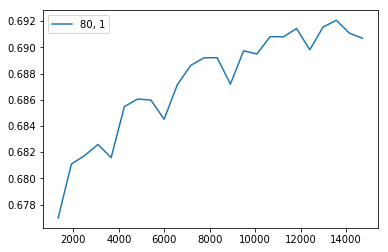

In [11]:
Plot(0, 'acc', '80, 1')
plt.legend()

# It is still going up so we could improve it by training longer.

In [13]:
modelList[0].save_weights('my_model_weights14k.h5')